In [15]:
import sys; print('Python:',sys.version)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.8.16 (default, Jan 17 2023, 23:13:24) 
[GCC 11.2.0]
Fastai: 2.5.3


In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from PIL import Image

## Load your data

In [17]:
path = '/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/food201/'
path_anno = path + 'gt/'
path_img = path + 'done/'

# function that takes ground truth image, given the original image path 

# get_y_fn = lambda originalImagePath : path_anno + '/' + f'{originalImagePath.stem}GT.png' #use for normal /done and /gt folders, like UNIMIB and BRUMAS
# get_y_fn = lambda originalImagePath : path_anno + '/' + originalImagePath.parent.stem + "/" + f'{originalImagePath.stem}GT.png' #use for aicrowd 
get_y_fn = lambda originalImagePath : path_anno + '/' + originalImagePath.parent.stem + "/" + f'{originalImagePath.stem}.png' #use for food201 
# get_y_fn = lambda originalImagePath : path_anno + '/' + originalImagePath.parent.stem + "_ann/" + f'{originalImagePath.stem}.png' #use for MyFood

In [18]:
np.random.seed(2) # same seed
randomSeed = 2

label_fnames = get_image_files(path_anno)
print(label_fnames[:3])
fnames = get_image_files(path_img)
print(fnames[:3])

len(fnames), len(label_fnames)

[Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/food201/gt/apple_pie/250066.png'), Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/food201/gt/apple_pie/2559009.png'), Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/food201/gt/apple_pie/2610524.png')]
[Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/food201/done/apple_pie/250066.jpg'), Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/food201/done/apple_pie/2559009.jpg'), Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/food201/done/apple_pie/2610524.jpg')]


(12093, 12093)

In [19]:
codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
# codesId = [code.split(": ")[0] for code in codes]
# codes = [code.split(": ")[1] for code in codes] 
len(codes)

202

/tmp/ipykernel_6016/508308399.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


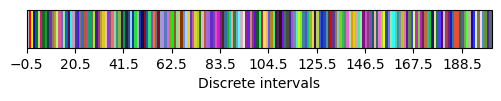

In [20]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) 
cmaplist[1] = "red" 
cmaplist[2] = "yellow" 
cmaplist[3] = "blue" 
cmaplist[4] = "green" 

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervals must contain integer values, so the bounds should increase every 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

## Check for noisy data

In [21]:
# check if ground truth is noisy (optional)

import cv2
import numpy as np

def isNoisyAnnotation(masks):

  #### check if masks have high iou between each other
  intersectionThreshold = 0.3
  for mask1 in masks: 
    for mask2 in masks: # compare every mask with each other 
      if not np.array_equal(mask1,mask2): 
        intersectionPixels = np.sum(np.logical_and(mask1, mask2))
        smallestMask = min(np.sum(mask1),np.sum(mask2))
        percentualIntersection = intersectionPixels / smallestMask
        # print(percentualIntersection)
        if percentualIntersection > intersectionThreshold:
          print("Masks with high intersection")
          return True

  #### check if exists multiple contours in one mask and if these regions are too small
  areaThreshold = 0.01
  maxContours = 1

  for mask in masks:    
    mask = mask * 255 # transform binary mask from (0,1) format to (0,255)

    # fig = plt.figure(figsize=(9,9))
    # ax1 = fig.add_subplot(1,2,1)
    # ax1.imshow(mask)
    # plt.show()

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    numContours = len(contours)

    for contour in contours:
      area = cv2.contourArea(contour)
      if area == 0.0:
        print("Found zero area")
        numContours -= 1
        continue

      totalPixels = mask.shape[0] * mask.shape[1]
      # print(area/totalPixels)
      if area/totalPixels < areaThreshold:
        # print("Very Small contour")
        return True

    # print(numContours)
    if numContours == 0:
      print("No contours")
      return True    

    if numContours > maxContours:
      # print("Multiple contours")
      return True

  return False

## Data visualization

In [22]:
# generate data visualization 

def getThickEdge(mask, rgbValues):
    edge = cv2.Canny(mask*255, 30, 150)

    kernel = np.ones((9,9), np.uint8)
    edge_dilated = cv2.dilate(edge, kernel, iterations=1)

    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[edge_dilated == 255], g[edge_dilated == 255], b[edge_dilated == 255] = rgbValues
    coloured_edge = np.stack([r, g, b], axis=2)

    # fig = plt.figure(figsize=(9,9))
    # ax1 = fig.add_subplot(1,2,1)
    # ax1.imshow(coloured_edge)
    # plt.show()

    return coloured_edge

    
def random_colour_masks(mask):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(mask).astype(np.uint8)
  g = np.zeros_like(mask).astype(np.uint8)
  b = np.zeros_like(mask).astype(np.uint8)
  randomNumber = random.randrange(0,10)
  r[mask == 1], g[mask == 1], b[mask == 1] = colours[randomNumber]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask, colours[randomNumber]

def mergeImgAndMasks(img, masks):

    for i in range(len(masks)):
        rgb_mask, rgbValues = random_colour_masks(masks[i])
        edge_mask = getThickEdge(masks[i], rgbValues)
        
        if img.shape != rgb_mask.shape:
            return None, None

        img = cv2.addWeighted(img, 1, rgb_mask, 0.2, 0)
        img = cv2.addWeighted(img, 1, edge_mask, 1, 0)

    return img

def getAllMasksAndClasses(mask):
  mask[mask >= len(codes)] = 0 # in case your dataset is not cleaned and does have pixel values out of range, remove them.
  ids = np.unique(mask) # instances are encoded as different colors
  ids = ids[1:] # first id is the background, so remove it
  classes = [codes[id] for id in ids]
  masks = mask == ids[:, None, None] # split the color-encoded mask into a set of binary masks
  masks = np.asarray(masks, dtype=np.uint8)

  return masks, classes

def getVisualization(fname, returnOriginalMask=False, checkNoisyAnnotation=True, classesToIgnore=[]):
    img = cv2.imread(str(fname))
    mask = cv2.imread(str(get_y_fn(fname)), cv2.IMREAD_GRAYSCALE)
    masks, classes = getAllMasksAndClasses(mask)

    intersection = list(set(classes) & set(classesToIgnore))
    if len(intersection) > 0: # classes to ignore were found
        # print(classes, classesToIgnore)
        # print("Found class to ignore")
        return None, None

    if checkNoisyAnnotation and isNoisyAnnotation(masks): # noisy image was found
        return None, None

    mergedImg = mergeImgAndMasks(img, masks)
    if mergedImg is None:
        print(fname)

    imgs = [cv2.imencode('.jpeg', mergedImg)[1].tobytes()]

    if returnOriginalMask:
        colorMask = cmap(mask, bytes=True)
        imgs.append(cv2.imencode('.jpeg', colorMask)[1].tobytes())
        
    return imgs, classes



    

## Iterate Data

In [23]:
# configuration

classesToIgnore = ["chocolate sauce", "powdered sugar"]
returnOriginalMask=True
checkNoisyAnnotation=True

# how many samples you want to iterate?
init = 0
end = 2

In [24]:
from IPython.display import display
from ipywidgets import widgets, HBox, VBox, GridBox, Layout

pickedSamples = []
samplesToIgnore = []

def createButton(file):
    layout = widgets.Layout()
    button = widgets.Button(description='Pick', layout = layout)

    def on_button_clicked(event, file=file):
        pickedSamples.append(file)
        button.description = "Done"
        button.disabled = True

    button.on_click(on_button_clicked)
    return button

items = []
for idx in range(init,end):
    imgs, classes = getVisualization(fnames[idx], returnOriginalMask=returnOriginalMask, checkNoisyAnnotation=checkNoisyAnnotation, classesToIgnore=classesToIgnore)
    
    if imgs is None: # found image with ids to ignore or noisy annotation
        samplesToIgnore.append(fnames[idx].name)
        continue       

    images = [widgets.Image(value=img,width=120,height=120) for img in imgs]
    button = createButton(fnames[idx].name)
    text = widgets.Label(value=str(len(classes)))

    visualization = [button, text] + images
    items.append(VBox(visualization))

grid = GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(8, 160px)"))

print(f"Ignored {len(samplesToIgnore)} samples")
display(grid)


Ignored 0 samples


GridBox(children=(VBox(children=(Button(description='Pick', style=ButtonStyle()), Label(value='2'), Image(valu…

In [25]:
print(len(pickedSamples))
print(pickedSamples)

print(len(samplesToIgnore))
print(samplesToIgnore)

0
[]
0
[]


In [43]:
# save picked images to file

filepath = path + f"pickedImages_init={init}_end={end}.txt"

textfile = open(filepath, "w")
for element in pickedSamples:
    textfile.write(element + "\n")
textfile.close()


In [44]:
# save ignored images to file

filepath = path + f"ignoredImages_init={init}_end={end}.txt"

textfile = open(filepath, "w")
for element in samplesToIgnore:
    textfile.write(element + "\n")
textfile.close()